# YouTube trending videos

In [49]:
from sklearn.model_selection import StratifiedKFold, KFold

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# import sys
#
# sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import accuracy_score, f1_score, precision_score, silhouette_score, roc_auc_score, recall_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.semi_supervised import LabelSpreading

from helpers.categories import get_categories_dict
from helpers.files import load_csv

## Etap 4 - Wykorzystanie uczenia pół-nadzorowanego


Deklaracja potrzebnych funkcji

In [50]:
def show_stats(y_hat, y_hat_nans, y, mapped: bool = False):
    if not mapped:
        mapping_dict = get_mapping_dict(y_hat_nans, y)
        print(mapping_dict)
        y_mapped = pd.Series(y).apply(lambda x: mapping_dict[x])
    else:
        y_mapped = pd.Series(y.astype(np.int))
        y_hat = y_hat.astype(np.int)
    print(f"Accuracy: {accuracy_score(y_hat, y_mapped)}")
    print(f"F1: {f1_score(y_hat, y_mapped, average='macro')}")
    print(f"Precision: {precision_score(y_hat, y_mapped, average='macro')}")
    print(f"Recall: {recall_score(y_hat, y_mapped, average='macro')}")
    print(f"Hat unique:{np.unique(y_hat.to_numpy())}")
    print(f"labeled unique: {np.unique(y_mapped.to_numpy())}")
    print(f"y_hat_nans : {np.unique(y_hat_nans[y_hat_nans.notna()].to_numpy())}")
    y_hat = y_hat.to_numpy().reshape(-1, 1)
    y_mapped = y_mapped.to_numpy().reshape(-1, 1)
    encoder = OneHotEncoder(sparse=False)
    one_hot_hat = encoder.fit_transform(y_hat)
    y_hot = encoder.transform(y_mapped)
    print(f"ROC AUC Score OVR: {roc_auc_score(one_hot_hat, y_hot, multi_class='ovr')}")
    print(f"ROC AUC Score OVO: {roc_auc_score(one_hot_hat, y_hot, multi_class='ovo')}")

### Wyczytanie danych

In [51]:
gb_data, us_data = load_csv("clustering_data")

videos = pd.concat([gb_data, us_data])
# inconsistency in data
videos["category_id"] = videos["category_id"].replace(43.0, 24.0)

categories_ids = videos["new_category_id"].dropna().unique().tolist()

### Wczytanie nazw kategorii

In [52]:
categories_dict = get_categories_dict()
categories = [categories_dict[cat] for cat in categories_ids]

## Usunięcie danych tekstowych

In [53]:
not_nan_bool = videos["new_category_id"].notna().reset_index(drop=True)

videos = videos[videos["new_category_id"].notna()]
videos = videos.reset_index(drop=True)
y_hat = videos["new_category_id"]  # oczekiwane kategorie z api
y_hat_nans = videos["category_id"]  # oczekiwane kategorie z nanami (z oryginalnego zbioru)
videos_no_nan_categories = videos[videos["category_id"].notna()]
selected_columns = [
    "views", "likes", "dislikes", "comment_count", "description_len", "title_len", "channel_title_len",
    "publish_time_day_of_week", "publish_time_hour_of_day",
    "gray_mean_score", "color_mean_score", "gray_hist_score",
    "red_hist_score", "green_hist_score", "blue_hist_score", "edges_score", "entropy_score",
]

for cat in categories_ids:
    selected_columns.append(f"freq_channel_titles_{categories_dict[cat]}")
    selected_columns.append(f"freq_titles_{categories_dict[cat]}")
    selected_columns.append(f"freq_tags_{categories_dict[cat]}")
    selected_columns.append(f"freq_descriptions_{categories_dict[cat]}")

videos = videos[selected_columns]
# videos = videos.fillna(videos.mean())

### Uzupełnienie wartości pustych wartościami średnimi


In [54]:
videos = videos.fillna(videos.mean())

### Skalowanie danych

In [55]:
scaler = MinMaxScaler()
videos = scaler.fit_transform(videos)

### Przygotowanie zbioru z oznaczonymi kategoriami

In [56]:
x_not_nan = videos[y_hat_nans.notna()]
y_not_nan = y_hat_nans[y_hat_nans.notna()]

x_only_nan = videos[y_hat_nans.isna()]

### K-means

Dobre acc (przypisuje wszyskim jedną klasę ale słaba reszta metryk)
można zastosować bo znamy liczbę klas, do których będziemy przypisywać.

In [57]:
def get_mapping_dict(y_hat_nans, y_pred) -> dict:
    values_counts = y_hat_nans.value_counts().reset_index(name="count")
    # print(values_counts)
    # print(f"Index: {values_counts.index}")
    most_frequent_class = values_counts["index"].iloc[0]
    # print(most_frequent_class)
    mapping_dict = {}
    y_data = pd.DataFrame()
    y_data["y_hat_nans"] = y_hat_nans
    y_data["y"] = y_pred
    y_data["c"] = 1
    y_data = y_data.groupby(["y", "y_hat_nans"])["c"].sum()  #.max(level=[0])#.sort_values().groupby(level=0)
    # print(y_data)
    out = y_data.loc[y_data.groupby(level=0).idxmax()]
    # print(out)
    for row in out.index:
        mapping_dict[row[0]] = row[1]
    for i in range(np.unique(y_pred).shape[0]):
        if i not in mapping_dict.keys():
            mapping_dict[i] = most_frequent_class
    return mapping_dict

(8735, 40)


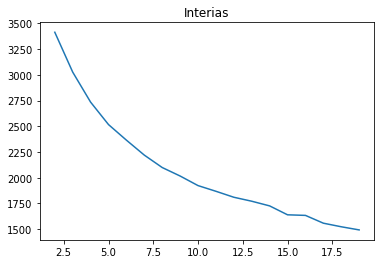

Cat len: 15
[ 8  7 10 ...  8  1  8]
{0: 28.0, 1: 24.0, 2: 23.0, 3: 17.0, 4: 24.0, 5: 25.0, 6: 24.0, 7: 10.0, 8: 24.0, 9: 10.0, 10: 1.0, 11: 10.0, 12: 26.0, 13: 24.0, 14: 27.0}
Accuracy: 0.4855180309101317
F1: 0.3240924039004475
Precision: 0.4437668293859653
Recall: 0.3034898783434978
Hat unique:[ 1.  2. 10. 15. 17. 19. 20. 22. 23. 24. 25. 26. 27. 28. 29.]
labeled unique: [ 1. 10. 17. 23. 24. 25. 26. 27. 28.]
y_hat_nans : [ 1.  2. 10. 15. 17. 19. 20. 22. 23. 24. 25. 26. 27. 28. 29.]
ROC AUC Score OVR: 0.6296480318125242
ROC AUC Score OVO: 0.6296480318125242


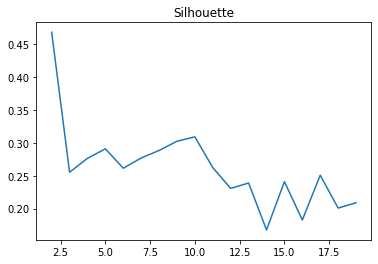

In [58]:
select = SelectKBest(chi2, k=40)
select.fit(x_not_nan, y_not_nan)
x_not_nan = select.transform(x_not_nan)
x_only_nan = select.transform(x_only_nan)
x = select.transform(videos)
print(x.shape)

k_list = np.arange(2, 20)
inertias = np.zeros_like(k_list, dtype=np.float)
silhouettes = np.zeros_like(k_list, dtype=np.float)
for i, k in enumerate(k_list):
    model = KMeans(k)
    # model.fit(x)
    labels = model.fit_predict(x)
    inertias[i] = model.inertia_
    silhouettes[i] = silhouette_score(x, labels)

plt.plot(k_list, inertias)
plt.title("Interias")
plt.show()
plt.plot(k_list, silhouettes)
plt.title("Silhouette")
print(f"Cat len: {len(categories)}")
model = KMeans(len(categories))
model.fit(x)
y = model.predict(x)
print(y)
show_stats(y_hat, y_hat_nans, y)


Semi supervised Constrained KMeans (punkt 3.1 z https://arxiv.org/pdf/1806.01547v2.pdf)

In [59]:
print(np.unique(y_not_nan))
print(categories)
# print(num_groups, len(categories))
print(x_not_nan.shape[0] + x_only_nan.shape[0], videos.shape[0])

[ 1.  2. 10. 15. 17. 19. 20. 22. 23. 24. 25. 26. 27. 28. 29.]
['Entertainment', 'People & Blogs', 'Sports', 'Music', 'Howto & Style', 'Gaming', 'Film & Animation', 'News & Politics', 'Comedy', 'Travel & Events', 'Education', 'Pets & Animals', 'Science & Technology', 'Autos & Vehicles', 'Nonprofits & Activism']
8735 8735


In [60]:
groups_index = np.unique(y_not_nan)
groups_dict = {e: i for i, e in enumerate(groups_index)}
num_groups = len(groups_index)

# print(groups_dict)

groups = [[] for _ in range(num_groups)]
for xp, yp in zip(x_not_nan, y_not_nan):
    groups[groups_dict[yp]].append(xp)

centroids = []
for g in groups:
    centroids.append(np.mean(g, axis=0))

centroids = np.array(centroids)
print(centroids.shape)


(15, 40)


In [61]:
new_centroids = centroids[:]

for itr in range(100):
    model = KMeans(n_clusters=num_groups, init=new_centroids, n_init=1, max_iter=1)
    labels = model.fit_predict(x_only_nan)
    new_groups = [[] for _ in range(num_groups)]
    for i, l in enumerate(labels):
        new_groups[l].append(x_only_nan[i])

    new_centroids = []
    for i, g in enumerate(new_groups):
        g = g + groups[i]
        new_centroids.append(np.mean(g, axis=0))
    new_centroids = np.array(new_centroids)

y = model.predict(select.transform(videos))
show_stats(y_hat, y_hat_nans, y)




{0: 1.0, 1: 25.0, 2: 10.0, 3: 15.0, 4: 17.0, 5: 19.0, 6: 24.0, 7: 24.0, 8: 24.0, 9: 24.0, 10: 25.0, 11: 26.0, 12: 27.0, 13: 28.0, 14: 24.0}
Accuracy: 0.47864911276473954
F1: 0.37322360830004414
Precision: 0.47051205030699156
Recall: 0.34747331012132326
Hat unique:[ 1.  2. 10. 15. 17. 19. 20. 22. 23. 24. 25. 26. 27. 28. 29.]
labeled unique: [ 1. 10. 15. 17. 19. 24. 25. 26. 27. 28.]
y_hat_nans : [ 1.  2. 10. 15. 17. 19. 20. 22. 23. 24. 25. 26. 27. 28. 29.]
ROC AUC Score OVR: 0.6513020608308715
ROC AUC Score OVO: 0.6513020608308715


AHC - bo mamy zdefiniowaną liczbę grup?

In [62]:
model = AgglomerativeClustering(len(categories), compute_full_tree=True)
# model = DBSCAN(eps=0.6, min_samples=5)
model.fit(x)
y = model.labels_

show_stats(y_hat, y_hat_nans, y)

{0: 17.0, 1: 19.0, 2: 1.0, 3: 24.0, 4: 28.0, 5: 10.0, 6: 24.0, 7: 25.0, 8: 26.0, 9: 23.0, 10: 24.0, 11: 10.0, 12: 24.0, 13: 22.0, 14: 27.0}
Accuracy: 0.5014310246136233
F1: 0.3664973615791801
Precision: 0.4915926505675612
Recall: 0.36195280168134963
Hat unique:[ 1.  2. 10. 15. 17. 19. 20. 22. 23. 24. 25. 26. 27. 28. 29.]
labeled unique: [ 1. 10. 17. 19. 22. 23. 24. 25. 26. 27. 28.]
y_hat_nans : [ 1.  2. 10. 15. 17. 19. 20. 22. 23. 24. 25. 26. 27. 28. 29.]
ROC AUC Score OVR: 0.6600414165005629
ROC AUC Score OVO: 0.6600414165005629


DBSCAN - bo mamy grupy różnej wielkości ?

In [63]:
model = DBSCAN(eps=0.1, min_samples=5)
model.fit(x)
y = model.labels_
show_stats(y_hat, y_hat_nans, y)

{-1: 24.0, 0: 24.0, 1: 17.0, 2: 10.0, 3: 10.0, 4: 10.0, 5: 10.0, 6: 10.0, 7: 24.0, 8: 24.0, 9: 26.0, 10: 10.0, 11: 24.0, 12: 22.0, 13: 22.0, 14: 22.0, 15: 24.0, 16: 24.0, 17: 24.0, 18: 24.0, 19: 10.0, 20: 24.0, 21: 23.0, 22: 27.0, 23: 24.0, 24: 24.0, 25: 24.0, 26: 26.0, 27: 24.0, 28: 17.0, 29: 24.0, 30: 10.0, 31: 24.0, 32: 25.0, 33: 10.0, 34: 22.0, 35: 10.0, 36: 17.0, 37: 10.0, 38: 25.0, 39: 26.0, 40: 10.0, 41: 10.0, 42: 10.0, 43: 10.0, 44: 1.0, 45: 22.0, 46: 27.0, 47: 10.0, 48: 10.0, 49: 26.0, 50: 10.0, 51: 10.0, 52: 10.0, 53: 10.0, 54: 1.0, 55: 22.0, 56: 24.0, 57: 24.0, 58: 28.0, 59: 19.0, 60: 24.0, 61: 24.0, 62: 10.0, 63: 26.0, 65: 10.0, 66: 24.0, 67: 10.0, 68: 10.0, 69: 1.0, 70: 10.0, 71: 17.0, 72: 17.0, 73: 10.0, 74: 24.0, 75: 20.0, 76: 25.0, 77: 23.0, 78: 23.0, 79: 23.0, 80: 10.0, 81: 10.0, 82: 10.0, 83: 10.0, 84: 23.0, 85: 17.0, 86: 24.0, 87: 10.0, 88: 22.0, 89: 15.0, 90: 24.0, 91: 24.0, 92: 24.0, 93: 1.0, 94: 24.0, 96: 10.0, 97: 10.0, 98: 23.0, 99: 10.0, 100: 24.0, 101: 24.0, 1

### DBSCAN eps Tuning

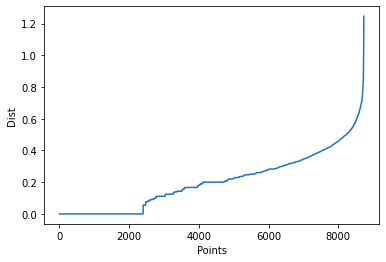

In [64]:
nn = NearestNeighbors(n_neighbors=11)
neighbors = nn.fit(x)
dist, ind = neighbors.kneighbors()

dist = np.sort(dist[:, 10], axis=0)

plt.plot(dist)
plt.xlabel("Points")
plt.ylabel("Dist")
plt.show()

### Label Spreading

TODO add cross validation as in TFidf

In [65]:
parameters = {'kernel': ["knn", "rbf"], 'gamma': [1, 10, 20, 30, 40], 'n_neighbors': [3, 5, 7, 11]}

best_auc = 0
best_params = None
scores = []

params = []
for k in parameters['kernel']:
    for g in parameters['gamma']:
        for n in parameters['n_neighbors']:
            params.append((k, g, n))
for p in tqdm(params):
    k, g, n = p
    model = LabelSpreading(kernel=k, gamma=g, n_neighbors=n)
    model.fit(x_not_nan, y_not_nan)
    y = model.predict(x_not_nan)
    y_mapped = y.reshape(-1, 1)
    encoder = OneHotEncoder(sparse=False)
    one_hot_hat = encoder.fit_transform(y_not_nan.to_numpy().reshape(-1, 1))
    y_hot = encoder.transform(y_mapped)
    score = roc_auc_score(one_hot_hat, y_hot, multi_class='ovr')
    scores.append((score, p))
    if score > best_auc:
        best_auc = score
        best_params = p

print(f"Best params: {best_params}")
print(f"BestScore: {best_auc}")
print(f"Scores: {scores}")



Best params: ('rbf', 40, 3)
BestScore: 0.8830199443538765
Scores: [(0.8400775543252744, ('knn', 1, 3)), (0.8340430919364412, ('knn', 1, 5)), (0.8156418826453523, ('knn', 1, 7)), (0.7882884501447591, ('knn', 1, 11)), (0.8400775543252744, ('knn', 10, 3)), (0.8340430919364412, ('knn', 10, 5)), (0.8156418826453523, ('knn', 10, 7)), (0.7882884501447591, ('knn', 10, 11)), (0.8400775543252744, ('knn', 20, 3)), (0.8340430919364412, ('knn', 20, 5)), (0.8156418826453523, ('knn', 20, 7)), (0.7882884501447591, ('knn', 20, 11)), (0.8400775543252744, ('knn', 30, 3)), (0.8340430919364412, ('knn', 30, 5)), (0.8156418826453523, ('knn', 30, 7)), (0.7882884501447591, ('knn', 30, 11)), (0.8400775543252744, ('knn', 40, 3)), (0.8340430919364412, ('knn', 40, 5)), (0.8156418826453523, ('knn', 40, 7)), (0.7882884501447591, ('knn', 40, 11)), (0.5230161912359381, ('rbf', 1, 3)), (0.5230161912359381, ('rbf', 1, 5)), (0.5230161912359381, ('rbf', 1, 7)), (0.5230161912359381, ('rbf', 1, 11)), (0.7620356638165514, (

### Trenowanie ostatecznego modelu

In [66]:
k, g, n = best_params
model = LabelSpreading(kernel=k, gamma=g, n_neighbors=n)
model.fit(x_not_nan, y_not_nan)
print(f"X not nan {x_not_nan.shape}")
print(f"X {x.shape}")
print(f"classes: {model.classes_}")
y = model.predict(x)
show_stats(y_hat, y_hat_nans, y, True)


X not nan (2733, 40)
X (8735, 40)
classes: [ 1.  2. 10. 15. 17. 19. 20. 22. 23. 24. 25. 26. 27. 28. 29.]
Accuracy: 0.687807670291929
F1: 0.6338906510984497
Precision: 0.8224637395762088
Recall: 0.5561277705957823
Hat unique:[ 1  2 10 15 17 19 20 22 23 24 25 26 27 28 29]
labeled unique: [ 1  2 10 15 17 19 20 22 23 24 25 26 27 28 29]
y_hat_nans : [ 1.  2. 10. 15. 17. 19. 20. 22. 23. 24. 25. 26. 27. 28. 29.]
ROC AUC Score OVR: 0.7649106183647054
ROC AUC Score OVO: 0.7649106183647054


## Dodatnie TfIdf


In [67]:
from ped4.tfidf import load_videos_with_tf_idf

videos = load_videos_with_tf_idf()


videos_not_nan = videos[y_hat_nans.notna()]
y_not_nan = y_hat_nans[y_hat_nans.notna()]

videos_only_nan = videos[y_hat_nans.isna()]

#
# select = SelectKBest(chi2, k=100)
# select.fit(x_not_nan, y_not_nan)
# x_not_nan = select.transform(x_not_nan)
# x_only_nan = select.transform(x_only_nan)
# x = select.transform(videos)
# print(x.shape)

parameters = {'k': np.arange(25, 100, 5), 'kernel': ["knn", "rbf"], 'gamma': [1, 10, 20, 30, 40],
              'n_neighbors': [3, 5, 7, 11]}

best_auc = 0
best_params = None
scores = []

params = []
k_splits = 10
cv = StratifiedKFold(n_splits=k_splits)
for k in parameters['k']:
    for kernel in parameters['kernel']:
        for g in parameters['gamma']:
            for n in parameters['n_neighbors']:
                params.append((k, kernel, g, n))

for p in tqdm(params):
    k, kernel, g, n = p
    select = SelectKBest(chi2, k=k)
    select.fit(videos_not_nan, y_not_nan)
    x_not_nan = select.transform(videos_not_nan)
    x_only_nan = select.transform(videos_only_nan)
    #x = select.transform(videos)
    mean_score = 0
    for i, (train, test) in enumerate(cv.split(x_not_nan, y_not_nan)):
        # print(type(x_not_nan))
        # print(type(y_not_nan))
        x_train = x_not_nan[train]
        y_train = y_not_nan.to_numpy()[train]

        x_test = x_not_nan[test]
        y_test = y_not_nan.to_numpy()[test]

        # print(f"{y_not_nan.value_counts()}")
        # print(f"Train: {np.unique(y_train)}")
        # print(f"Test: {np.unique(y_test)}")

        model = LabelSpreading(kernel=kernel, gamma=g, n_neighbors=n)
        model.fit(x_train, y_train)
        y = model.predict(x_test)
        # print(f"Y pred: {y}")
        # print(y_test)
        y_mapped = y.reshape(-1, 1)
        encoder = OneHotEncoder(sparse=False)
        encoder.fit(y_train.reshape(-1, 1))
        one_hot_hat = encoder.transform(y_test.reshape(-1, 1))
        y_hot = encoder.transform(y_mapped)
        # print(one_hot_hat)
        score = roc_auc_score(one_hot_hat, y_hot, average='micro', multi_class='ovr')
        mean_score += score
    mean_score /= k_splits
    scores.append((mean_score, p))
    if mean_score > best_auc:
        best_auc = mean_score
        best_params = p

print(f"Best params: {best_params}")
print(f"BestScore: {best_auc}")
print(f"Scores: {scores}")


All: 9623
Tfidf: (9623, 200)
All: 9623
Tfidf: (9623, 200)
All: 9623
Tfidf: (9623, 200)
(8735, 200)
(8735, 200)
(8735, 200)



Best params: (95, 'rbf', 30, 3)
BestScore: 0.8210504302787932
Scores: [(0.7224315048871881, (25, 'knn', 1, 3)), (0.7320325659741718, (25, 'knn', 1, 5)), (0.73261481740366, (25, 'knn', 1, 7)), (0.7385089493405448, (25, 'knn', 1, 11)), (0.7224315048871881, (25, 'knn', 10, 3)), (0.7320325659741718, (25, 'knn', 10, 5)), (0.73261481740366, (25, 'knn', 10, 7)), (0.7385089493405448, (25, 'knn', 10, 11)), (0.7224315048871881, (25, 'knn', 20, 3)), (0.7320325659741718, (25, 'knn', 20, 5)), (0.73261481740366, (25, 'knn', 20, 7)), (0.7385089493405448, (25, 'knn', 20, 11)), (0.7224315048871881, (25, 'knn', 30, 3)), (0.7320325659741718, (25, 'knn', 30, 5)), (0.73261481740366, (25, 'knn', 30, 7)), (0.7385089493405448, (25, 'knn', 30, 11)), (0.7224315048871881, (25, 'knn', 40, 3)), (0.7320325659741718, (25, 'knn', 40, 5)), (0.73261481740366, (25, 'knn', 40, 7)), (0.7385089493405448, (25, 'knn', 40, 11)), (0.6461945249745042, (25, 'rbf', 1, 3)), (0.6461945249745042, (25, 'rbf', 1, 5)), (0.646194524974

### Trenowanie modelu z TfIdf

In [69]:
k, kernel, g, n = best_params

select = SelectKBest(chi2, k=k)
select.fit(videos_not_nan, y_not_nan)
x_not_nan = select.transform(videos_not_nan)
x_only_nan = select.transform(videos_only_nan)
x = select.transform(videos)

model = LabelSpreading(kernel=kernel, gamma=g, n_neighbors=n)
model.fit(x_not_nan, y_not_nan)
print(f"X not nan {x_not_nan.shape}")
print(f"X {x.shape}")
print(f"classes: {model.classes_}")
y = model.predict(x)
show_stats(y_hat, y_hat_nans, y, True)

X not nan (2733, 95)
X (8735, 95)
classes: [ 1.  2. 10. 15. 17. 19. 20. 22. 23. 24. 25. 26. 27. 28. 29.]
Accuracy: 0.697424155695478
F1: 0.6464181575612742
Precision: 0.8219152627272037
Recall: 0.5729235372306422
Hat unique:[ 1  2 10 15 17 19 20 22 23 24 25 26 27 28 29]
labeled unique: [ 1  2 10 15 17 19 20 22 23 24 25 26 27 28 29]
y_hat_nans : [ 1.  2. 10. 15. 17. 19. 20. 22. 23. 24. 25. 26. 27. 28. 29.]
ROC AUC Score OVR: 0.7736032058667834
ROC AUC Score OVO: 0.7736032058667834
